In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [3]:
# pip install datasets --quiet

In [4]:
# pip install transformers

Import Dataset and Model

In [5]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [6]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

# def longformer_finetuned_papers():
#     model = AutoModelForSequenceClassification.from_pretrained('danielhou13/longformer-finetuned_papers', num_labels = 2, output_attentions = True)
#     return model

# def preprocess_function(tokenizer, example, max_length):
#     example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
#     return example

# def get_papers_dataset(dataset_type):
#     max_length = 2048
#     dataset = load_dataset("danielhou13/cogs402dataset")[dataset_type]

#     # tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#     dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)
#     setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
#     setattr(dataset, 'target_columns', ['labels'])
#     setattr(dataset, 'max_length', max_length)
#     setattr(dataset, 'tokenizer', tokenizer)
#     return dataset

# def papers_train_set():
#     return get_papers_dataset('train')

# def papers_test_set():
#     return get_papers_dataset('test')

In [7]:
def preprocess_function(tokenizer, example, max_length):
    example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
    return example

def longformer_finetuned_news():
    model = AutoModelForSequenceClassification.from_pretrained('danielhou13/longformer-finetuned-news-cogs402', num_labels = 2)
    return model

def get_news_dataset(dataset_type):
    max_length = 2048
    dataset = load_dataset("danielhou13/cogs402dataset2")[dataset_type]

    tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
    dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)

    labels = map(int, dataset['hyperpartisan'])
    print(type(dataset['hyperpartisan']))
    labels = list(labels)
    dataset = dataset.add_column("labels", labels)

    dataset = dataset.remove_columns(['title', 'hyperpartisan', 'url', 'published_at', 'bias'])
    print(dataset)
    setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
    setattr(dataset, 'target_columns', ['labels'])
    setattr(dataset, 'max_length', max_length)
    setattr(dataset, 'tokenizer', tokenizer)
    return dataset

def news_train_set():
    return get_news_dataset('train')

def news_test_set():
    return get_news_dataset('validation')

In [8]:
cogs402_test = news_test_set()
model = longformer_finetuned_news()
columns = cogs402_test.input_columns + cogs402_test.target_columns
print(columns)
cogs402_test.set_format(type='torch', columns=columns)
cogs402_test=cogs402_test.remove_columns(['text'])

Using custom data configuration danielhou13--cogs402dataset2-5e8e10311524cdf9
Reusing dataset parquet (C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset2-5e8e10311524cdf9\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset2-5e8e10311524cdf9\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901\cache-160dd1c9a047f43f.arrow


<class 'list'>
Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2500
})
['input_ids', 'attention_mask', 'labels']


In [9]:
if torch.cuda.is_available():
    model = model.cuda()

print(model.device)

cuda:0


Take example for evaluation

In [10]:
testexam = cogs402_test[923]

In [11]:
# print(test['labels'][923])

In [12]:
output = model(testexam["input_ids"].unsqueeze(0).cuda(), attention_mask=testexam['attention_mask'].unsqueeze(0).cuda(), labels=testexam['labels'].cuda(), output_attentions = True)
batch_attn = output[-2]
output_attentions = torch.stack(batch_attn).cpu()
global_attention = output[-1]
output_global_attentions = torch.stack(global_attention).cpu()
print("output_attention.shape", output_attentions.shape)
print("gl_output_attention.shape", output_global_attentions.shape)

output_attention.shape torch.Size([12, 1, 12, 2048, 514])
gl_output_attention.shape torch.Size([12, 1, 12, 2048, 1])


In [13]:
# print(os.getcwd())
# yes = torch.load("resources/longformer_test2/epoch_3/aggregate_attn.pt")

Convert sliding attention matrix to correct seq_len x seq_len matrix

In [14]:
def create_head_matrix(output_attentions, global_attentions):
    new_attention_matrix = torch.zeros((output_attentions.shape[0], 
                                      output_attentions.shape[0]))
    for i in range(output_attentions.shape[0]):
        test_non_zeroes = torch.nonzero(output_attentions[i]).squeeze()
        test2 = output_attentions[i][test_non_zeroes[1:]]
        new_attention_matrix_indices = test_non_zeroes[1:]-257 + i
        new_attention_matrix[i][new_attention_matrix_indices] = test2
        new_attention_matrix[i][0] = output_attentions[i][0]
        new_attention_matrix[0] = global_attentions.squeeze()[:output_attentions.shape[0]]
    return new_attention_matrix


def attentions_all_heads(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = create_head_matrix(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return torch.stack(new_matrix)

def all_batches(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = attentions_all_heads(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return torch.stack(new_matrix)

def all_layers(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = all_batches(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return torch.stack(new_matrix)

In [15]:
converted_mat = all_layers(output_attentions, output_global_attentions).detach().cpu().numpy()
print(converted_mat.shape)

(12, 1, 12, 2048, 2048)


View the attention plot for this example

In [16]:
def format_attention_image(attention):
    formatted_attn = []
    for layer_idx in range(attention.shape[0]):
        print("layer", layer_idx)
        for head_idx in range(attention.shape[1]):
            formatted_entry = {
                'layer': layer_idx,
                'head': head_idx
            }

            # Flatten value of log attention normalize between 255 and 0
            if len(attention[layer_idx, head_idx]) == 0:
                continue
            attn = np.array(attention[layer_idx, head_idx]).flatten()
            attn = (attn - attn.min()) / (attn.max() - attn.min())
            alpha = np.round(attn * 255)
            red = np.zeros_like(alpha) * 255
            green = np.zeros_like(alpha) * 255
            
            blue = np.ones_like(alpha) * 255

            attn_data = np.dstack([red,green,blue,alpha]).reshape(alpha.shape[0] * 4).astype('uint8')
            formatted_entry['attn'] = attn_data.tolist()
            formatted_attn.append(formatted_entry)
    return formatted_attn

In [17]:
example_attention = format_attention_image(converted_mat.squeeze())

layer 0
layer 1
layer 2
layer 3
layer 4
layer 5
layer 6
layer 7
layer 8
layer 9
layer 10
layer 11


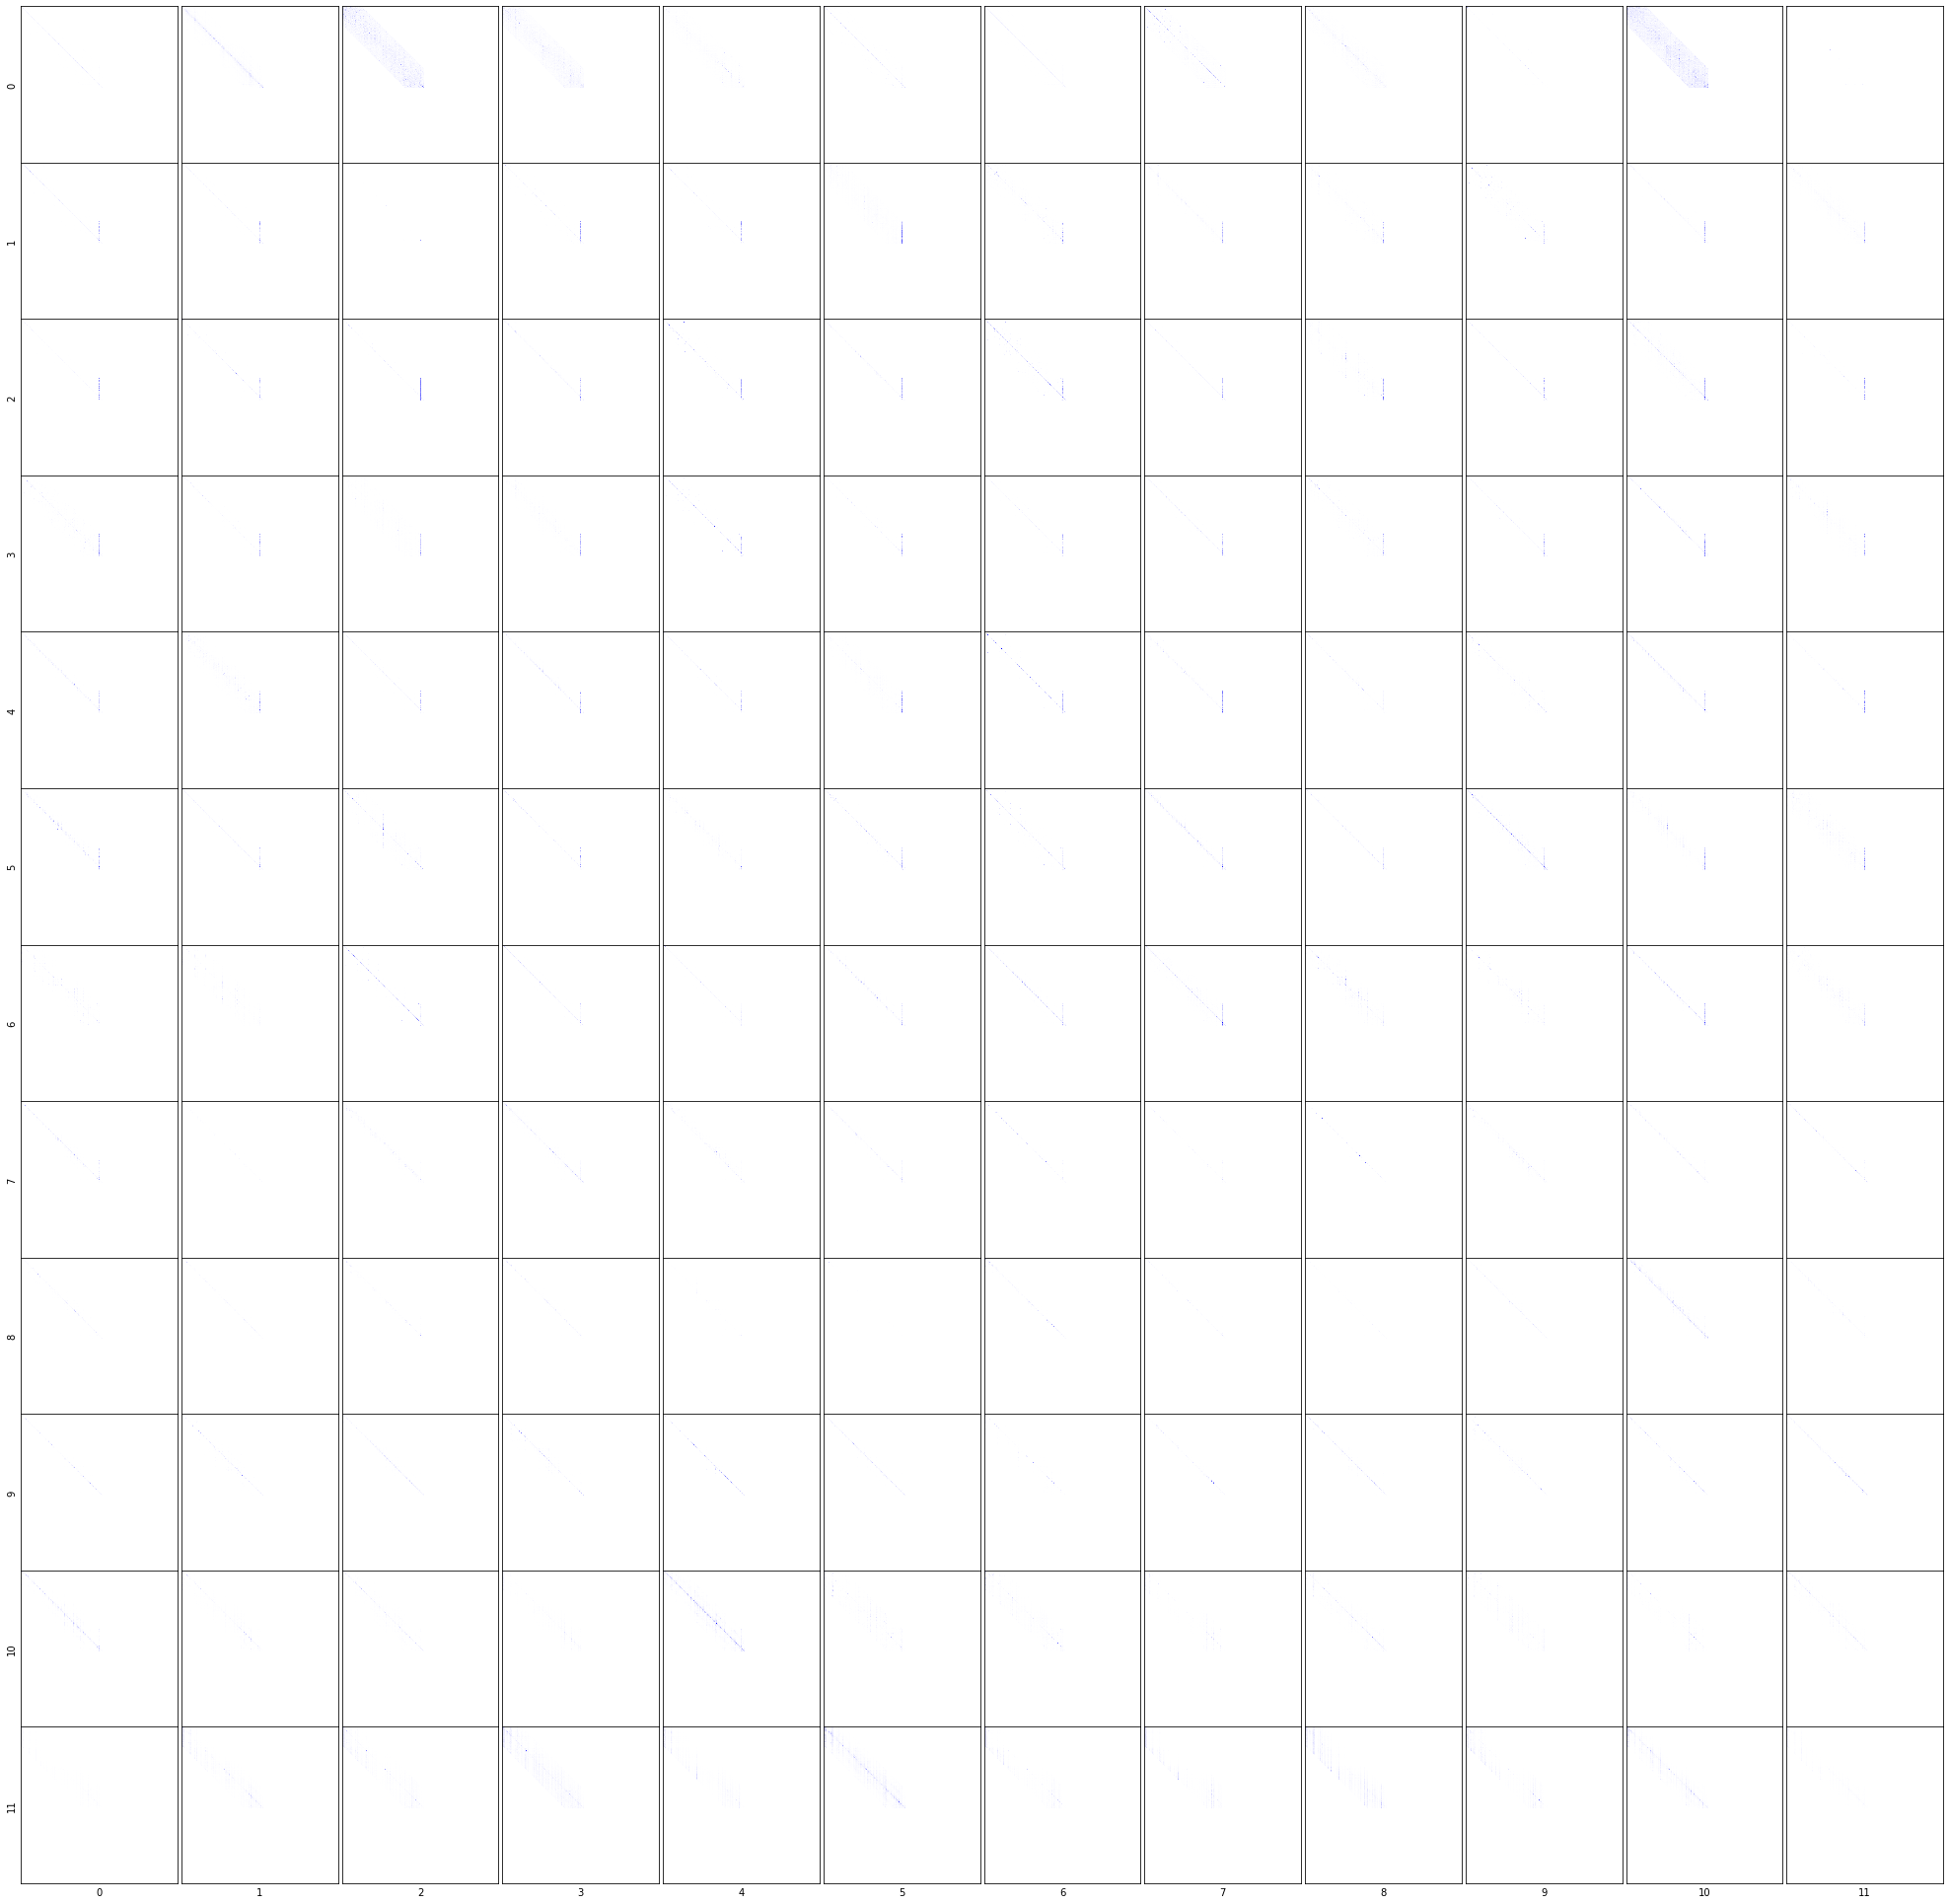

In [18]:
import math 
fig, axs = plt.subplots(12,12,figsize=(35,35))
row_num=0
for i in range(len(example_attention)):
    test2 = np.array(example_attention[i]['attn']).reshape((2048,2048,4))
    col_num = i%12
    row_num = math.floor(i/12)
    c= axs[row_num, col_num].imshow(test2, interpolation="nearest")
    axs[row_num, col_num].set(xlabel = str(col_num), ylabel = str(row_num))
    axs[row_num, col_num].xaxis.set_ticks([])
    axs[row_num, col_num].yaxis.set_ticks([])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()